# Machine Learning for Chemistry: Predicting Molecular Properties

## Lab Overview

In this lab, you will use machine learning to predict molecular properties from chemical descriptors. **You don't need to be an expert programmer** — the code is already written for you. Your job is to:

1. **Run** each cell to see what happens
2. **Experiment** by changing highlighted parameters
3. **Observe** how results change
4. **Reflect** on what those changes tell you about machine learning

### Learning Objectives

By the end of this lab, you will be able to:
- Understand how molecular features relate to chemical properties
- Explain what training and testing a model means
- Describe how regularization prevents overfitting
- Compare linear vs. non-linear ML models
- Interpret model performance metrics (R², MSE)

### Dataset

We use data from: **Fang Liu, Chenru Duan, and Heather J. Kulik**, *J. Phys. Chem. Lett.* 2020, 11, 8067–8076.

- **4,865 transition metal complexes**
- **157 molecular descriptors** (RACs — Revised Autocorrelations)
- **Target**: rND (a multireference diagnostic — tells us how hard it is to model a molecule with standard DFT)
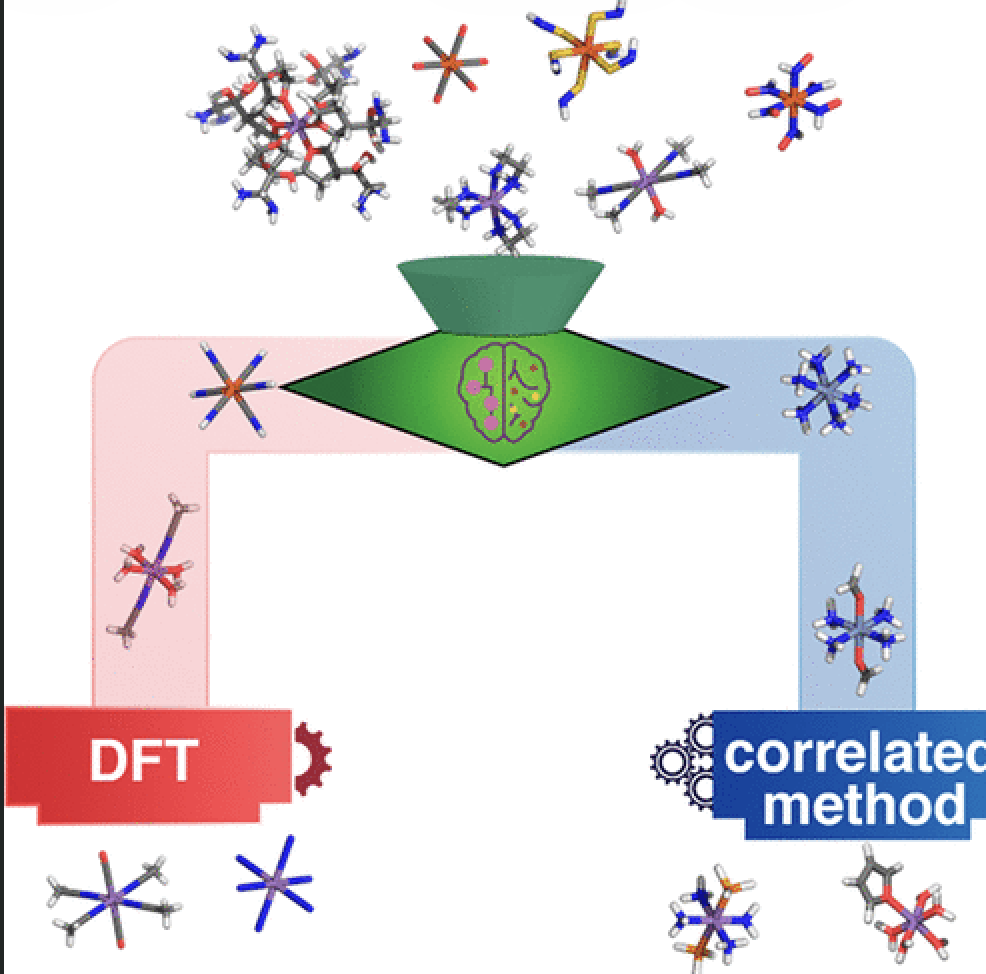



This study tackles a major bottleneck in computational chemical discovery: the reliability of Density Functional Theory (DFT) when applied to complex transition metal systems.

1. The Problem: When DFT Fails
While DFT is the "workhorse" of chemical simulation, it struggles with open-shell 3d transition metals. These systems often have strong multireference (MR) character—meaning their electronic structure is too complex for standard DFT equations to describe accurately.

2. Key Findings
HOMO–LUMO Gap Myth: The study proves that a small HOMO–LUMO gap (traditionally a sign of reactivity) does not correlate with high MR character. You cannot use the gap to predict if DFT will fail.

FON-based Diagnostics: The researchers used Fractional Occupation Number (FON)-based methods as an affordable way to "flag" these problematic MR regions.

Scalability: By training Machine Learning (ML) models on 4,800 complexes, they were able to screen a massive library of ~187,000 theoretical complexes almost instantaneously.

---
## Setup: Import Libraries

Run this cell first. It loads the tools we need. You don't need to change anything here.

In [ ]:
#! pip install scikit-learn matplotlib pandas numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, r2_score

plt.rcParams.update({'font.size': 10, 'figure.figsize': (8, 6)})
np.random.seed(42)
print('Libraries loaded successfully!')

---
## Part 1: Load and Explore the Data

Run the cell below to load the dataset and see its basic structure.

In [ ]:
# Load the data
datapath = ''
modelpath = os.path.join(datapath, 'models')

features_file = os.path.join(modelpath, 'Data/refined_datasets/refined_features.csv')
properties_file = os.path.join(modelpath, 'Data/refined_datasets/refined_properties.csv')

df_features = pd.read_csv(features_file)
df_props = pd.read_csv(properties_file)

print(f'Features dataset shape: {df_features.shape}')
print(f'Properties dataset shape: {df_props.shape}')
print(f'Number of molecules: {len(df_features)}')
print(f'\nFirst few feature column names:')
print(list(df_features.columns[:10]))

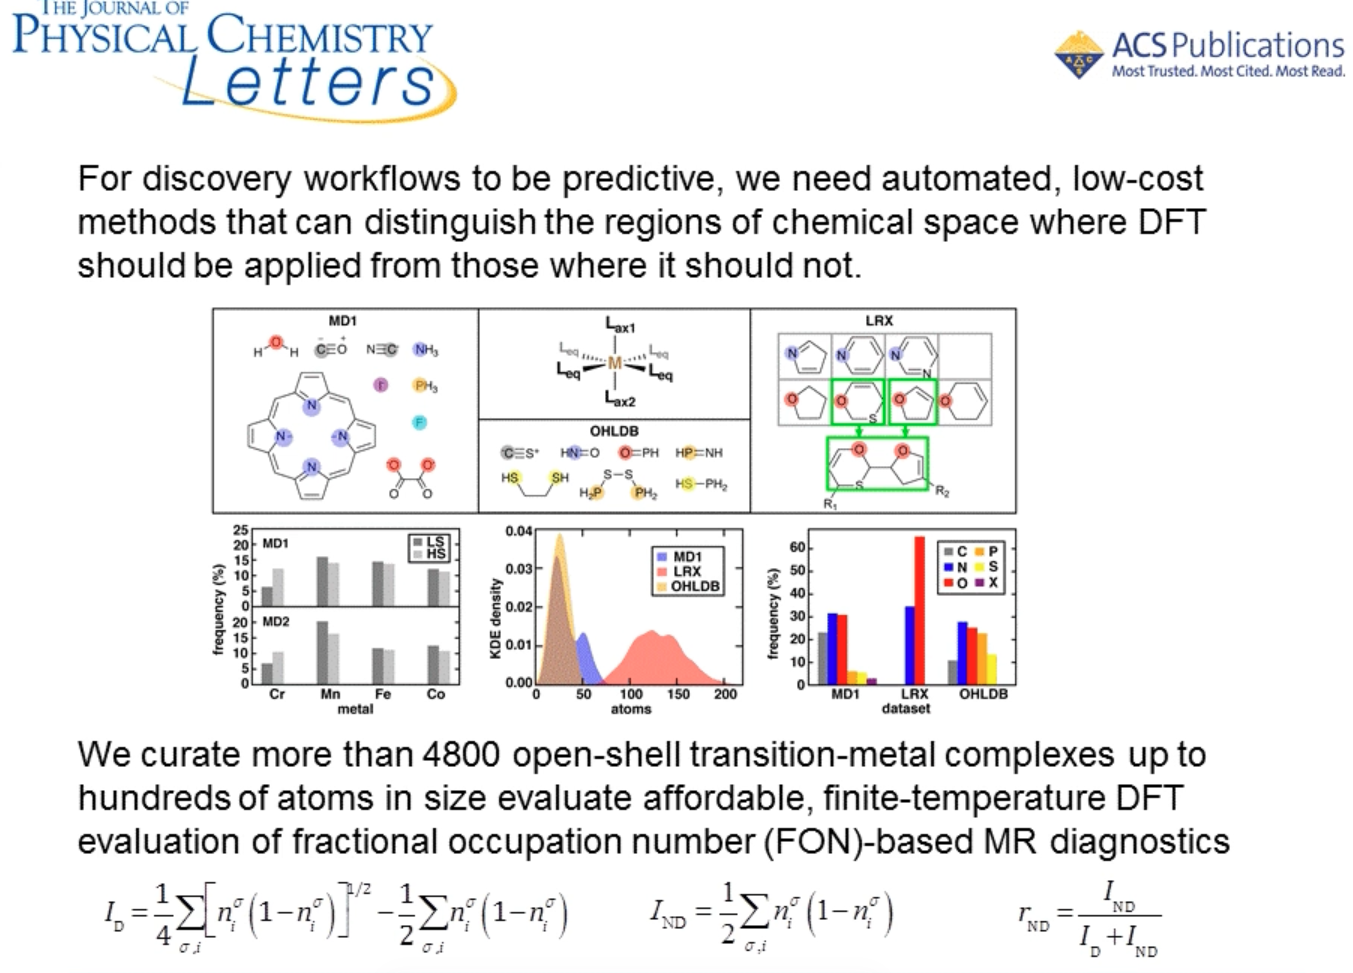

##  FON-Based Multireference (MR) Diagnostics

The researchers utilize **Fractional Occupation Numbers (FONs)** to distinguish between different types of electron correlation. This approach is designed to be a "high-speed" alternative to expensive quantum chemistry calculations.

---

### 1. The Method: FT-DFT
The core of this approach is **Finite-Temperature Density Functional Theory (FT-DFT)**.
* **Computational Cost:** It is described as **"computationally affordable,"** meaning it can be run on large systems (hundreds of atoms) where high-level MR methods would normally crash or take months to solve.



### 2. The Diagnostics: Splitting Correlation
The method splits electron correlation into two distinct mathematical quantities based on orbital occupation ($n_{i,\sigma}$):

* **Dynamical Correlation ($I_D$):** Represents the "standard" interactions between electrons.
* **Nondynamical/MR Correlation ($I_{ND}$):** Specifically flags Multireference character. Higher values indicate that a single-reference method (like standard DFT) is likely to fail.





### 3. The "Size-Intensive" Indicator ($r_{ND}$)
To make the diagnostic useful across different molecular sizes, they use the ratio $r_{ND}$:

$$r_{ND} = \frac{I_{ND}}{I_D + I_{ND}}$$

* **Interpretation:** A larger $r_{ND}$ value serves as a red flag for **strong MR character**.
* **Advantage:** Because it is a ratio (**size-intensive**), it allows researchers to compare a small catalyst to a large protein-bound complex on the same scale.

In [ ]:
# Visualize the target property: rND
rnd = df_props['rND']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(rnd, bins=50, color='steelblue', alpha=0.8, edgecolor='white')
axes[0].set_xlabel('rND value')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of rND (target property)')

axes[1].scatter(df_props['energeticGap (eV)'], rnd, alpha=0.2, s=5, color='steelblue')
axes[1].set_xlabel('HOMO-LUMO Gap (eV)')
axes[1].set_ylabel('rND')
axes[1].set_title('HOMO-LUMO Gap vs. rND')

plt.tight_layout()
plt.show()

print(f'rND mean: {rnd.mean():.3f}  |  std: {rnd.std():.3f}  |  range: [{rnd.min():.3f}, {rnd.max():.3f}]')

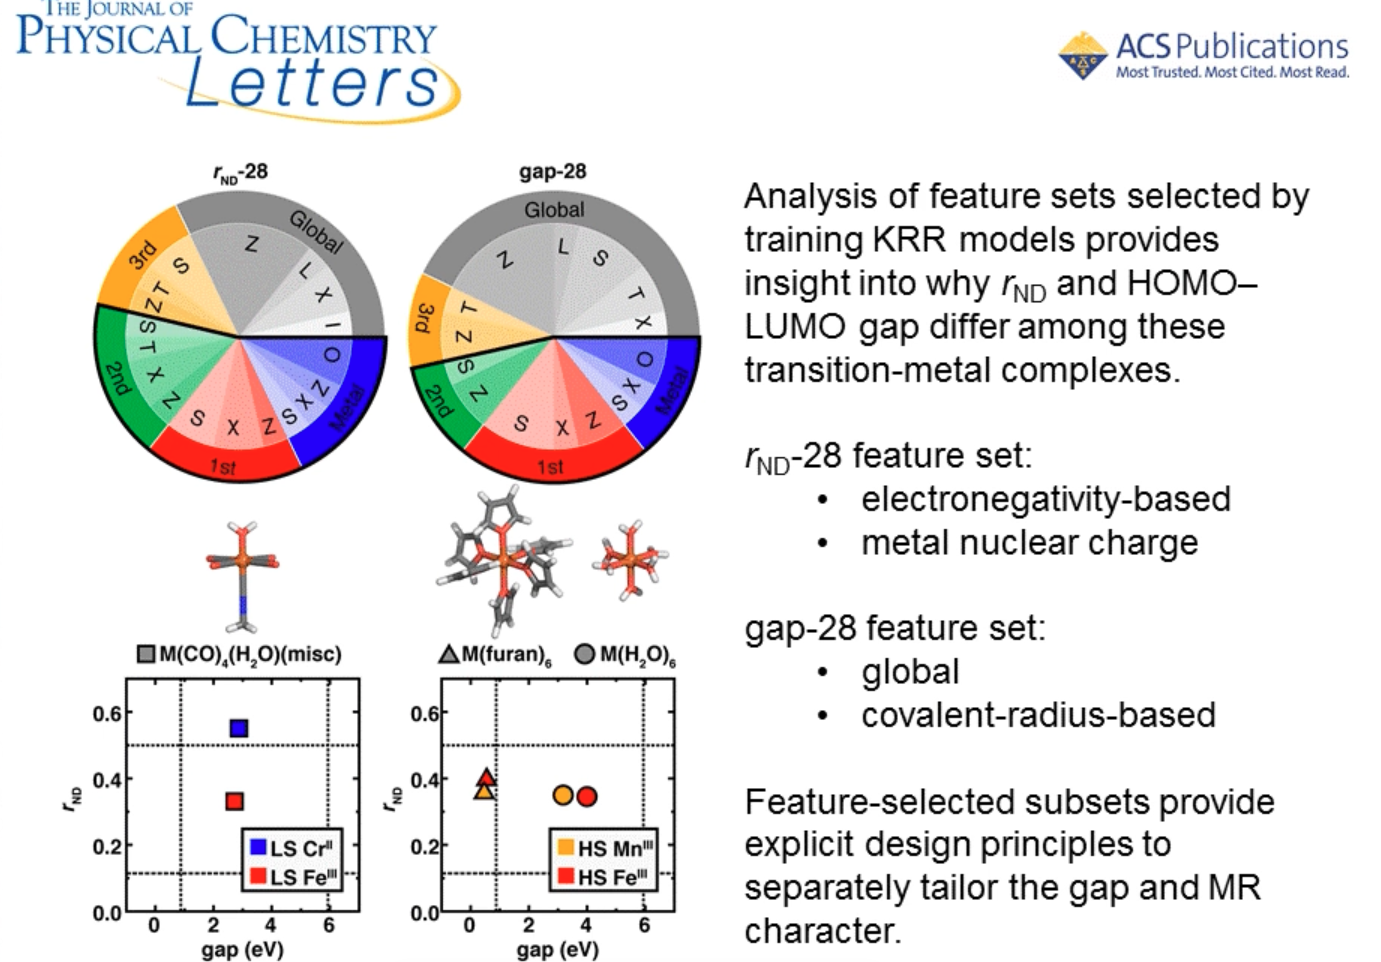

---
## Part 2: A Simple Model — Single Feature

### Concept: What is a regression model?
A regression model tries to find a mathematical relationship between **input features** (things we can measure about a molecule) and an **output property** (what we want to predict — here, rND).

We start simple: can we predict rND from just **one** feature?

### Step 2.1 — Run the model

The cell below trains a linear regression using the HOMO-LUMO gap as the only feature. Run it and observe the results.

In [ ]:
# ── DEMO CELL (run as-is) ────────────────────────────────────────────────────
# We use the HOMO-LUMO gap as our single feature
X_single = df_props[['energeticGap (eV)']].values
y = df_props['rND'].values

# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_single, y, test_size=0.2, random_state=42)

# Scale features (zero mean, unit variance)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# Train a linear regression model
model_single = LinearRegression()
model_single.fit(X_train_s, y_train)

# Evaluate
y_pred = model_single.predict(X_test_s)
r2  = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'=== Single-Feature Model (HOMO-LUMO Gap) ===')
print(f'Test R²:  {r2:.4f}  (1.0 = perfect, 0 = no better than guessing the mean)')
print(f'Test MSE: {mse:.6f}')

# Plot
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred, alpha=0.3, s=10, color='steelblue')
lim = [y.min(), y.max()]
plt.plot(lim, lim, 'r--', label='Perfect prediction')
plt.xlabel('True rND')
plt.ylabel('Predicted rND')
plt.title('Single Feature: Predicted vs. True rND')
plt.legend()
plt.tight_layout()
plt.show()

### Step 2.2 — Experiment: Try a different feature

The HOMO-LUMO gap was just one choice. What if we used a different property as our feature?

**Your task:** Change the `feature_to_use` variable below to try different features. Run the cell after each change and observe how R² changes.

**Available features to try:**
| Variable name | Chemistry meaning |
|---|---|
| `'energeticGap (eV)'` | HOMO-LUMO gap |
| `'energeticHOMO (eV)'` | HOMO energy |
| `'spin'` | Spin state of the complex |
| `'ox'` | Metal oxidation state |
| `'FOD'` | Fractional occupation density |
| `'I_ND'` | Non-dynamic correlation index |

In [ ]:
# ── EXPERIMENT CELL ──────────────────────────────────────────────────────────
#  CHANGE THIS: try different features from the table above
feature_to_use = 'energeticGap (eV)'   # <-- change this

# ── (do not change the code below) ───────────────────────────────────────────
X_exp = df_props[[feature_to_use]].values
y_exp = df_props['rND'].values

X_tr, X_te, y_tr, y_te = train_test_split(X_exp, y_exp, test_size=0.2, random_state=42)
scaler_exp = StandardScaler()
X_tr_s = scaler_exp.fit_transform(X_tr)
X_te_s = scaler_exp.transform(X_te)

model_exp = LinearRegression().fit(X_tr_s, y_tr)
y_pred_exp = model_exp.predict(X_te_s)

print(f'Feature: {feature_to_use}')
print(f'Test R²:  {r2_score(y_te, y_pred_exp):.4f}')
print(f'Test MSE: {mean_squared_error(y_te, y_pred_exp):.6f}')

plt.figure(figsize=(6, 5))
plt.scatter(y_te, y_pred_exp, alpha=0.3, s=10, color='darkorange')
lim = [y_exp.min(), y_exp.max()]
plt.plot(lim, lim, 'r--')
plt.xlabel('True rND')
plt.ylabel('Predicted rND')
plt.title(f'Single Feature: {feature_to_use}')
plt.tight_layout()
plt.show()

**Reflection 2.2** — Answer in the cell below:
- Which single feature gave the best R²? 
- Why do you think no single feature can predict rND very well?

*Your answer here...*

---
## Part 3: Multi-Feature Linear Regression

### Concept: More features = better model?
Instead of one feature, we now use all 154 molecular descriptors (RACs). Let's see if more information helps.

### Step 3.1 — Run the multi-feature model

Run the cell below to train a linear regression using all features.

In [ ]:
# Helper function to select features (locked — do not change)
def select_features(df, cols_selected=None):
    keys = ['RACs']
    removed_columns = []
    if cols_selected is None:
        return_columns = ['ligcharge', 'ox', 'spin']
        for col in df.columns:
            for key in keys:
                if key in col and 'init' not in col and 'misc' not in col:
                    if 'Zeff' not in col and '-O-' not in col:
                        return_columns.append(col)
    else:
        return_columns = cols_selected
    df = df.dropna(subset=return_columns)
    threshold = 1e-4
    final_cols = [col for col in return_columns if np.std(df[col].values) >= threshold]
    removed_columns = [col for col in return_columns if col not in final_cols]
    print(f'Initial features: {len(return_columns)}')
    print(f'Removed (low variance): {len(removed_columns)}')
    print(f'Final features: {len(final_cols)}')
    return final_cols, df

In [ ]:
# ── DEMO CELL (run as-is) ────────────────────────────────────────────────────
cols_use, df_clean = select_features(df_features)

X_all = df_features[cols_use].values
y_rnd = df_props['rND'].values

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_all, y_rnd, test_size=0.2, random_state=42
)

scaler_all = StandardScaler()
X_train_all_s = scaler_all.fit_transform(X_train_all)
X_test_all_s  = scaler_all.transform(X_test_all)

model_all = LinearRegression()
model_all.fit(X_train_all_s, y_train_all)

y_pred_all_train = model_all.predict(X_train_all_s)
y_pred_all_test  = model_all.predict(X_test_all_s)

r2_train_all = r2_score(y_train_all, y_pred_all_train)
r2_test_all  = r2_score(y_test_all,  y_pred_all_test)
mse_test_all = mean_squared_error(y_test_all, y_pred_all_test)

print(f'=== Multi-Feature Linear Regression (All {len(cols_use)} features) ===')
print(f'Train R²: {r2_train_all:.4f}')
print(f'Test  R²: {r2_test_all:.4f}')
print(f'Test MSE: {mse_test_all:.6f}')
print(f'\nNote: if Train R² >> Test R², the model is OVERFITTING.')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, y_true, y_pred, label in [
    (axes[0], y_train_all, y_pred_all_train, f'Train  R²={r2_train_all:.3f}'),
    (axes[1], y_test_all,  y_pred_all_test,  f'Test   R²={r2_test_all:.3f}'),
]:
    ax.scatter(y_true, y_pred, alpha=0.2, s=8, color='steelblue')
    lim = [y_rnd.min(), y_rnd.max()]
    ax.plot(lim, lim, 'r--')
    ax.set_xlabel('True rND')
    ax.set_ylabel('Predicted rND')
    ax.set_title(label)
plt.suptitle('All Features — Linear Regression', fontweight='bold')
plt.tight_layout()
plt.show()

### Step 3.2 — Experiment: Change the train/test split

The `test_size` parameter controls how much data is held out for testing. A larger test set = less data for training.

**Your task:** Try different values and observe how Train R² and Test R² change.

In [ ]:
# ── EXPERIMENT CELL ──────────────────────────────────────────────────────────
#  CHANGE THIS: fraction of data used for testing (between 0.05 and 0.5)
test_size = 0.2    # <-- try 0.05, 0.1, 0.3, 0.5

# ── (do not change the code below) ───────────────────────────────────────────
X_tr2, X_te2, y_tr2, y_te2 = train_test_split(X_all, y_rnd, test_size=test_size, random_state=42)
scaler2 = StandardScaler()
X_tr2_s = scaler2.fit_transform(X_tr2)
X_te2_s = scaler2.transform(X_te2)

m = LinearRegression().fit(X_tr2_s, y_tr2)
r2_tr = r2_score(y_tr2, m.predict(X_tr2_s))
r2_te = r2_score(y_te2, m.predict(X_te2_s))

print(f'Test size: {test_size*100:.0f}%  |  Train size: {(1-test_size)*100:.0f}%')
print(f'Train R²: {r2_tr:.4f}')
print(f'Test  R²: {r2_te:.4f}')
print(f'Gap (Train-Test): {r2_tr - r2_te:.4f}  ← large gap = overfitting')

**Reflection 3.2** — Answer in the cell below:
- What happens to the gap between Train R² and Test R² when you use less training data?
- Can you explain in your own words what **overfitting** means?

*Your answer here...*

---
## Part 4: Regularization — Elastic Net

### Concept: What is regularization?
When a model has too many features, it can **overfit** — it learns the training data perfectly but fails on new data. Regularization adds a *penalty* that discourages the model from relying too heavily on any single feature.

**Elastic Net** mixes two regularization strategies:
- **L1 (Lasso)**: Pushes some coefficients to exactly zero → automatic feature selection
- **L2 (Ridge)**: Shrinks all coefficients smoothly

Two parameters control Elastic Net:
| Parameter | Meaning | Effect of higher value |
|---|---|---|
| `alpha` | Overall regularization strength | Simpler model, may underfit |
| `l1_ratio` | Mix of L1 vs L2 (0=Ridge, 1=Lasso) | Closer to 1 = more features set to zero |

### Step 4.1 — Run the Elastic Net model

In [ ]:
# ── DEMO CELL (run as-is) ────────────────────────────────────────────────────
model_en = ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=5000)
model_en.fit(X_train_all_s, y_train_all)

y_pred_en = model_en.predict(X_test_all_s)
r2_en  = r2_score(y_test_all, y_pred_en)
mse_en = mean_squared_error(y_test_all, y_pred_en)
nonzero = np.sum(model_en.coef_ != 0)

print(f'=== Elastic Net (alpha=0.001, l1_ratio=0.5) ===')
print(f'Test R²:  {r2_en:.4f}')
print(f'Test MSE: {mse_en:.6f}')
print(f'Features used (non-zero coeff): {nonzero} / {len(cols_use)}')

plt.figure(figsize=(6, 5))
plt.scatter(y_test_all, y_pred_en, alpha=0.3, s=8, color='green')
plt.plot([y_rnd.min(), y_rnd.max()], [y_rnd.min(), y_rnd.max()], 'r--')
plt.xlabel('True rND')
plt.ylabel('Predicted rND')
plt.title(f'Elastic Net — Test R²={r2_en:.3f}')
plt.tight_layout()
plt.show()

### Step 4.2 — Experiment: Tune the regularization

**Your task:** Change `alpha` and `l1_ratio` and observe how:
1. Test R² changes
2. The number of features used changes

**Suggested values to try:**
- `alpha`: 0.0001, 0.001, 0.01, 0.1, 1.0
- `l1_ratio`: 0.1 (mostly Ridge), 0.5 (balanced), 0.9 (mostly Lasso)

In [ ]:
# ── EXPERIMENT CELL ──────────────────────────────────────────────────────────
#  CHANGE THESE TWO PARAMETERS:
alpha    = 0.001   # <-- try: 0.0001, 0.001, 0.01, 0.1, 1.0
l1_ratio = 0.5     # <-- try: 0.1, 0.5, 0.9  (0=Ridge only, 1=Lasso only)

# ── (do not change the code below) ───────────────────────────────────────────
m_en = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=5000)
m_en.fit(X_train_all_s, y_train_all)
y_p = m_en.predict(X_test_all_s)

print(f'alpha={alpha}, l1_ratio={l1_ratio}')
print(f'Test R²:  {r2_score(y_test_all, y_p):.4f}')
print(f'Test MSE: {mean_squared_error(y_test_all, y_p):.6f}')
print(f'Features used: {np.sum(m_en.coef_ != 0)} / {len(cols_use)}')

**Reflection 4.2** — Answer in the cell below:
- What happens to R² when `alpha` is very large? What about very small?
- When `l1_ratio` is close to 1.0, many features are set to zero. Why might that be useful in chemistry?

*Your answer here...*

---
## Part 5: Kernel Ridge Regression (Non-linear Model)

### Concept: Going non-linear
Linear models assume that the relationship between features and the target is a straight line (or hyperplane). But chemistry is complex — relationships are often **non-linear**.

**Kernel Ridge Regression (KRR)** uses a mathematical trick called a "kernel" to implicitly model non-linear relationships. The **kernel** defines how the model measures similarity between molecules:

| Kernel | Meaning |
|---|---|
| `'rbf'` | Radial Basis Function — smooth, general-purpose |
| `'linear'` | Same as linear regression |
| `'poly'` | Polynomial relationships |

The `gamma` parameter in the RBF kernel controls how "wide" the similarity measure is.

### Step 5.1 — Run the KRR model

In [ ]:
# ── DEMO CELL (run as-is) ────────────────────────────────────────────────────
# Note: KRR can be slow with many features. We use a subset for speed.
model_krr = KernelRidge(kernel='rbf', alpha=0.01, gamma=0.01)
model_krr.fit(X_train_all_s, y_train_all)

y_pred_krr = model_krr.predict(X_test_all_s)
r2_krr  = r2_score(y_test_all, y_pred_krr)
mse_krr = mean_squared_error(y_test_all, y_pred_krr)

print(f'=== Kernel Ridge Regression (rbf kernel) ===')
print(f'Test R²:  {r2_krr:.4f}')
print(f'Test MSE: {mse_krr:.6f}')

plt.figure(figsize=(6, 5))
plt.scatter(y_test_all, y_pred_krr, alpha=0.3, s=8, color='purple')
plt.plot([y_rnd.min(), y_rnd.max()], [y_rnd.min(), y_rnd.max()], 'r--')
plt.xlabel('True rND')
plt.ylabel('Predicted rND')
plt.title(f'Kernel Ridge Regression — Test R²={r2_krr:.3f}')
plt.tight_layout()
plt.show()

### Step 5.2 — Experiment: Change the kernel and parameters

**Your task:** Try different kernels and values of `gamma` and `alpha`.

In [ ]:
# ── EXPERIMENT CELL ──────────────────────────────────────────────────────────
#  CHANGE THESE PARAMETERS:
kernel = 'rbf'   # <-- try: 'rbf', 'linear', 'poly'
gamma  = 0.01    # <-- try: 0.001, 0.01, 0.1, 1.0  (only matters for 'rbf' and 'poly')
alpha  = 0.01    # <-- regularization strength (try: 0.001, 0.01, 0.1)

# ── (do not change the code below) ───────────────────────────────────────────
m_krr = KernelRidge(kernel=kernel, alpha=alpha, gamma=gamma)
m_krr.fit(X_train_all_s, y_train_all)
y_p = m_krr.predict(X_test_all_s)

print(f'kernel={kernel}, gamma={gamma}, alpha={alpha}')
print(f'Test R²:  {r2_score(y_test_all, y_p):.4f}')
print(f'Test MSE: {mean_squared_error(y_test_all, y_p):.6f}')

**Reflection 5.2** — Answer in the cell below:
- Did the RBF kernel outperform the linear kernel? What does that tell you about the structure of this data?
- What happened when you set `gamma` very high (e.g., 1.0)?

*Your answer here...*

---
## Part 6: Model Comparison

Now let's bring all your results together. Run the cell below — it will summarize what you found across all models.

> **Note:** This cell uses the results from the **demo cells** (Parts 2–5). Make sure you ran all demo cells before running this one.

In [ ]:
# ── DEMO CELL (run as-is) ────────────────────────────────────────────────────
# Gather results from demo cells
results = {
    'Single Feature\n(Gap only)': r2_score(y_test, model_single.predict(scaler.transform(df_props[['energeticGap (eV)']].values[list(range(len(y_test)))]))),
    'All Features\n(154 RACs)':   r2_test_all,
    'Elastic Net\n(α=0.001)':     r2_en,
    'Kernel Ridge\n(RBF)':        r2_krr,
}

# Recompute single feature r2 cleanly
X_s_all = df_props[['energeticGap (eV)']].values
_, X_te_s_all, _, y_te_s_all = train_test_split(X_s_all, y_rnd, test_size=0.2, random_state=42)
sc = StandardScaler().fit(X_s_all[:int(len(X_s_all)*0.8)])
r2_single_final = r2_score(y_te_s_all, model_single.predict(sc.transform(X_te_s_all)))

results = {
    'Single Feature\n(Gap only)': r2_single_final,
    'All Features\n(154 RACs)':   r2_test_all,
    'Elastic Net\n(α=0.001)':     r2_en,
    'Kernel Ridge\n(RBF)':        r2_krr,
}

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2']
bars = ax.bar(results.keys(), results.values(), color=colors, alpha=0.85, edgecolor='black')
for bar, score in zip(bars, results.values()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
ax.set_ylabel('Test R² Score', fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.05)
ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.4, label='Perfect model (R²=1)')
ax.grid(axis='y', alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

print('\nModel | R²')
for name, score in sorted(results.items(), key=lambda x: -x[1]):
    print(f'  {name.replace(chr(10)," "):35s} {score:.4f}')

---
## Final Reflection

Answer the questions below in the markdown cell provided. There are no wrong answers — we are looking for thoughtful reasoning.

**1. Why did using all 154 features not dramatically improve over a single feature for linear regression?**

*Your answer...*

---
**2. Regularization (Elastic Net) added a penalty to the model. In plain language, what problem does this solve, and why is that important in chemistry?**

*Your answer...*

---
**3. The Kernel Ridge Regression model (non-linear) likely outperformed the linear models. What does this suggest about how molecular features relate to rND?**

*Your answer...*

---
**4. If you were a computational chemist and needed to choose one model to deploy in practice, which would you pick and why? Consider both accuracy and interpretability.**

*Your answer...*

---
## Key Takeaways

- **More features ≠ better model** — without regularization, more features can hurt (overfitting)
- **Regularization is crucial** — it prevents overfitting and can perform automatic feature selection (Lasso/Elastic Net)
- **Non-linear models capture complexity** — KRR can model interactions that linear models miss
- **Interpretability vs. accuracy trade-off** — simpler models are easier to understand but may be less accurate
- **Domain knowledge matters** — choosing the right features and model type benefits from chemistry understanding

##  Congratulations!

You've explored four different ML approaches on a real molecular dataset, experimented with key parameters, and connected algorithmic choices to chemical insight.